**EmoReCom** is a multimodal/fusion model for emotion recognition in comic scenes. This is bornt for the ICDAR 2021 competition. More details is available [here](https://github.com/aisutd/emorecom). Feel free to fork it, and use it as the code base to compete in the ICDAR 2021 competition.

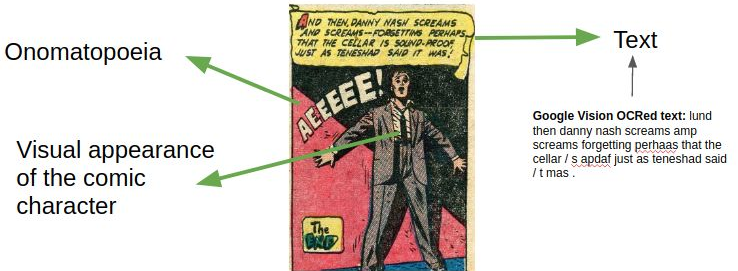

**Goals:** Angy Disgust Fear Happy Sad Surprise Neutral Others


## Import dependencies

In [52]:
# download codes
!git clone https://github.com/aisutd/emorecom.git -b workshop
!unzip emorecom/saved_models/model.zip

# download pretrained model
!gdown https://drive.google.com/uc?id=1Yajk0bTMytLPt1YQHptqnl4bpffPR7Gw
!unzip model.zip

fatal: destination path 'emorecom' already exists and is not an empty directory.
unzip:  cannot find or open emorecom/saved_models/model.zip, emorecom/saved_models/model.zip.zip or emorecom/saved_models/model.zip.ZIP.
Downloading...
From: https://drive.google.com/uc?id=1Yajk0bTMytLPt1YQHptqnl4bpffPR7Gw
To: /content/model.zip
533MB [00:02, 235MB/s]
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/gdown/cli.py", line 61, in main
    quiet=args.quiet,
  File "/usr/local/lib/python2.7/dist-packages/gdown/download.py", line 109, in download
    shutil.copy(tmp_file, output)
  File "/usr/lib/python2.7/shutil.py", line 139, in copy
    copyfile(src, dst)
  File "/usr/lib/python2.7/shutil.py", line 98, in copyfile
    copyfileobj(fsrc, fdst)
  File "/usr/lib/python2.7/shutil.py", line 66, in copyfileobj
    fdst.write(buf)
KeyboardInterrupt
Archive:  model.zip
  End-of-central-directory sig

In [53]:
# import dependencies
import os
import re
import cv2
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# import TF layers
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, GlobalAveragePooling1D, Conv2D, Dropout, BatchNormalization, Dense, Flatten, LSTM, Bidirectional, Embedding

# set random seed
tf.random.set_seed(2021)
np.random.seed(seed = 2021)

In [54]:
# do not modify these configs
MODEL_CONFIGS= {'img_shape' : [224, 224, 3],
                'text_len' : 128,
                'vocabs' : None,
                'vocab_size' : 10000,
                'embed_dim' : 100,
                'pretrained_embed' : None,
                'num_class' : 8}

## Inputs/Data Processing

## investigate sample

that ' s just the begin - ning ? ive even bigger jobs planned ha ha well make the police dance to the minstrel ' s tunes !



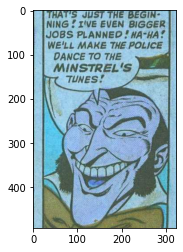

In [20]:
image = cv2.imread('/content/emorecom/dataset/ws_test.jpg')
text = open('/content/emorecom/dataset/ws_test.txt').read()
print(text)
plt.imshow(image)

### Image Processing

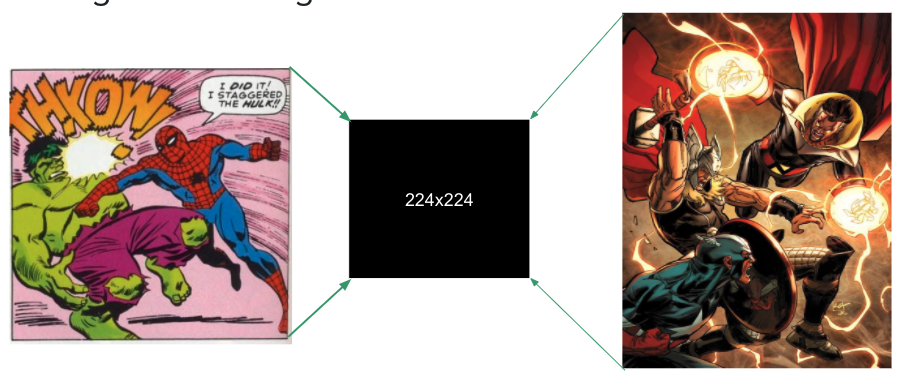

In [21]:
"""------------------------------image-processing-------------------------------------------"""
@tf.function
def image_proc(image, size):
	"""
	image_proc - function to process image while training. Up to designs
	Inputs:
		- image : Tensor
			List of image tensors
		- size : tuple
			Tuple of (height, width) of the desired image's shape
		- overlap_ratio : float
			To be added
	Outputs:
		- image : Tensor
			Post-processed image
	"""

	# resize image
	image = tf.image.resize_with_crop_or_pad(image, size[0], size[1])

	# standarize
	image = tf.image.per_image_standardization(image)

	return image

In [22]:
# process image
img = image_proc(image, MODEL_CONFIGS['img_shape'][:2]) # img_shape = [224,244]
print("Original dimension of image", image.shape)
print("Resized dimension off image", img.shape)

Original dimension of image (493, 325, 3)
Resized dimension off image (224, 224, 3)


### Text Processing
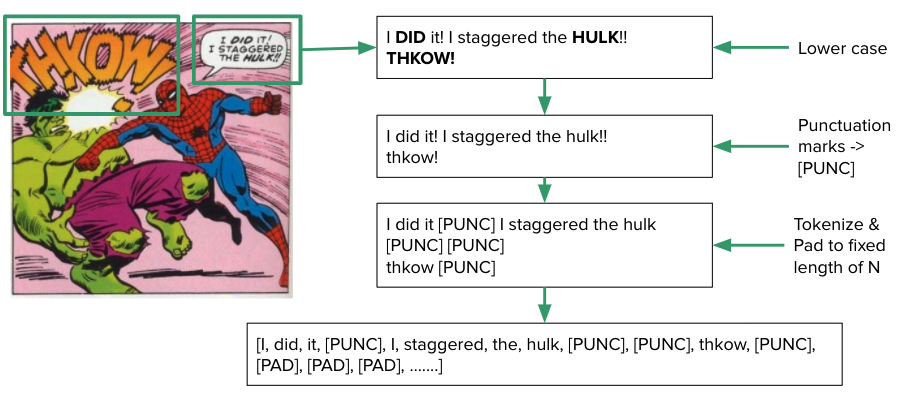

In [25]:
"""------------------------------text-processing-------------------------------------------"""
@tf.function
def lookup(tokens, file):
  """
	lookup - function to decode tokens based on the given dictionary
  Inputs:
    - tokens : TF tokens
    - file : path to the dictionary
  Outputs:
    - _ : decoded tokens
	"""
  # set up dict
  def _set_up_dict():
    initializer =  tf.lookup.TextFileInitializer(filename = file,
      key_dtype = tf.string, key_index = tf.lookup.TextFileIndex.WHOLE_LINE,
      value_dtype = tf.int64, value_index = tf.lookup.TextFileIndex.LINE_NUMBER)
    
    return tf.lookup.StaticHashTable(initializer, default_value = 0)

  vocabs = _set_up_dict()

  # decode tokens
  return vocabs.lookup(tokens)

@tf.function
def text_proc(text, max_len):
	"""
	text_proc - function to perform fundamental text-processing (not considering WordPiece Tokenizer)
	Inputs:
		- text : Tensor of String
		- max_len : integer
			Maximum number of tokens in a sequence
	Outputs:
		- text :  Tensor of string
			Post-processed string
	"""

	# lower case
	text = tf.strings.lower(text)

	# flatten punctuations and short-forms
	text = regex_replace(text)

	# remove trivial whitespace
	text = tf.strings.regex_replace(text, pattern = "\s+", rewrite = " ")

	# join string together
	text = tf.strings.reduce_join(text, separator = '[SEP]')

	# tokenize (split by space)
	text = tf.strings.split(text)

	# padding 
	text = tf.cond(pred = tf.math.greater(tf.size(text), max_len),
		true_fn = lambda: tf.slice(text, begin = [0], size = [max_len]),
		false_fn = lambda : pad_text(text, max_len))

	return text

@tf.function
def pad_text(text, max_len):
	"""
	pad_text - function to pad [PAD] token to string
	Inputs:
		- text : Tensor of string
		- max_len : integer
			Maximum number of tokens in a sequence
	Outputs: 
		- _ : Tensor of string
			Post-processed string
	"""
	paddings = tf.repeat(tf.constant('[PAD]'),
		repeats = max_len - tf.size(text))

	return tf.concat([text, paddings], axis = 0)

@tf.function
def regex_replace(text):
	"""
	regex_replace - function to flatten punctuations and short-forms
	Inputs:
		- text : Tensor of string
	Outputs:
		- _ : Tensor of String
			Post-processed string 
	"""
	def _func(inputs):
		"""
		_func - function to perform regex-replace
		"""
		# replace n't with not
		inputs = tf.strings.regex_replace(inputs,
			pattern = "n't",
			rewrite = " not")

		# replace: 'm, 's, 're with be
		inputs = tf.strings.regex_replace(inputs,
			pattern = "\'s|\'re|\'m",
			rewrite = " be")

		# replace punctuations with [PUNC] mark
		inputs = tf.strings.regex_replace(inputs,
			pattern = "[^a-zA-Z\d\s]",
			rewrite = " [PUNC] ")

		return inputs

	return _func(text) if text.dtype.is_compatible_with(tf.string) else tf.constant("")

In [27]:
# process text
tokens = text_proc(text, MODEL_CONFIGS['text_len']) # text_len = 128

# decode tokens
d_tokens = lookup(tokens, '/content/emorecom/dataset/vocabs.txt')

print("Original text\n", text)
print()
print("Processed text\n", tokens)
print()
print("Decoded tokens\n", d_tokens)

Original text
 that ' s just the begin - ning ? ive even bigger jobs planned ha ha well make the police dance to the minstrel ' s tunes !


Processed text
 tf.Tensor(
[b'that' b'[PUNC]' b's' b'just' b'the' b'begin' b'[PUNC]' b'ning'
 b'[PUNC]' b'ive' b'even' b'bigger' b'jobs' b'planned' b'ha' b'ha' b'well'
 b'make' b'the' b'police' b'dance' b'to' b'the' b'minstrel' b'[PUNC]' b's'
 b'tunes' b'[PUNC]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[P

## Feature Extraction

### CNN for extracting visual features
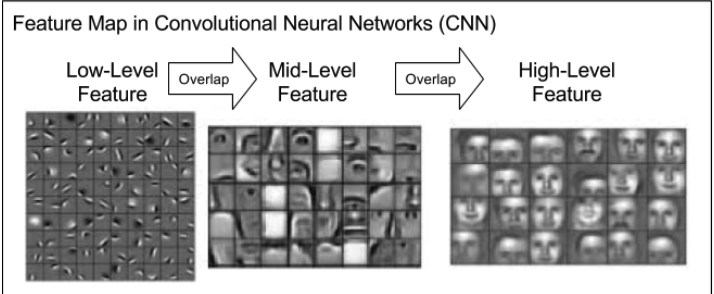


In [9]:
def vision(img_shape):
	"""
	vision - function to create visual module
	Inputs:
		- img_shape : tuple of integers
			[width, height, channel]
	Outputs:
		- _ : Tensorflow Keras Model
	"""
	inputs = Input(shape = img_shape, name = 'image')

	outputs = tf.keras.applications.ResNet50(include_top = False,
		weights = 'imagenet', input_shape = img_shape)(inputs)

	return Model(inputs = inputs, outputs = outputs)

In [10]:
# create vision module
vision_module = vision(MODEL_CONFIGS['img_shape'])
print(vision_module.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________
None


### RNN for extracting textual features
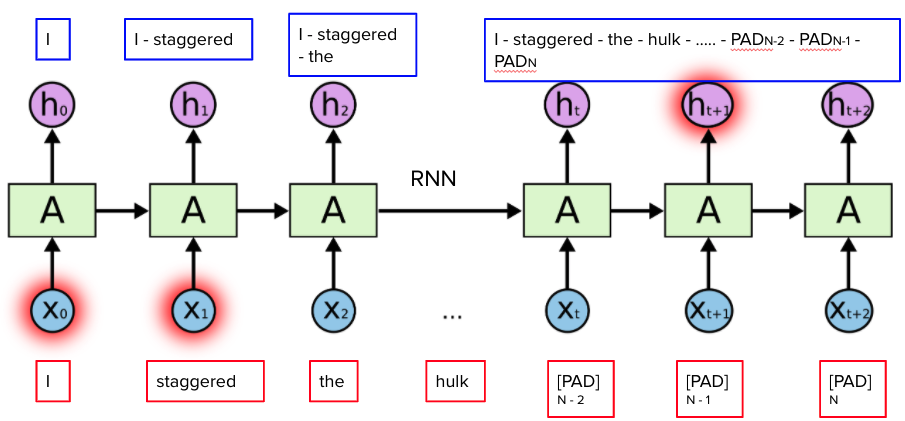

In [11]:
def BiLSTM(forward_units, backward_units, return_sequences = True):
	"""
	BiLSTM - function to create the Bidirection-LSTM layer
	Inputs:
		- forward_units : integer
			Number of units for the forward direction
		- bachward_units : integer
			Number of units for the baackward direction
	Outputs:
		- _ : Tensorflow Keras Layer - Bidirectional object
	"""
	forward = LSTM(forward_units, return_sequences = return_sequences)
	backward = LSTM(backward_units, return_sequences = return_sequences, go_backwards = True)

	return Bidirectional(layer = forward, backward_layer = backward, merge_mode = 'concat')

def EmbeddingLayer(embed_dim = None, vocabs = None, vocab_size = None, max_len = None, pretrained = None):
  """
	EmbeddingLayer - function to initializer Embedding layer
  Inputs:
    - embed_dim : integer
      Dimension size of the Embedding layer
    - vocabs : path to vocab file
    - vocab_size : number of vocabularies
      If vocabs is None, vocabo_size must be a valid integer
    - max_len : integer
      Maximum number of tokens in a sequence
    - pretrained : string
      Path to the pretraiend word embeddings. Glove Word-Embedding is used by default
  Outputs:
    - _ : Tensorflow Embedding layer
  """

  # retrieve vocab-size
  # index-0 for out-of-vocab token
  if vocabs:
    # read vocabs
    with open(vocabs) as file:
      vocabs = file.read().split('\n')[:-1]
    vocab_size = len(vocabs)
  else:
    # if vocabs not given, then vocab-size must not be None
    assert vocab_size != None

	# load pretrained word-embeddings
  if pretrained:
    # retrieve pretrained word embeddings
    embed_index = {}
    with open(pretrained) as file:
      for line in file:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, 'f', sep = ' ')
        embed_index[word] = coefs

    # initialize new word embedding matrics
    embed_dim = len(list(embed_index.values())[0])
    embeds = np.random.uniform(size = (vocab_size, embed_dim))
		
    # parse words to pretrained word embeddings
    for i, word in enumerate(vocabs):
      embed = embed_index.get(word)
      if embed is not None:
        embeds[i] = embed

    initializer = Constant(embeds)
  else:
    initializer = 'uniform'

  return Embedding(input_dim = vocab_size, output_dim = embed_dim,
    input_length = max_len, mask_zero = True,
    embeddings_initializer = initializer,
    embeddings_regularizer = None)
	
def text(text_len = None, vocabs = None, vocab_size = None, embed_dim = None, pretrained_embed = None):
	"""
	text - function to create textual module
	Inputs:
		- text_len : integer
			Max length of text, default = None
		- vocabs : str
			Path to dictionary file
		- vocab_size : integer
			Number of vocabs, None by default
		- embed_dim : integer
			Dimension size of the Embedding layer
		- pretrained_embed : str, None by default
			Path to the pretrained embedding file
	Outputs:
		- _ : Tensorflow Keras Model
	"""

	# initialize input
	inputs = Input(shape = [text_len], name = 'transcripts')

	# initializer Embedding layer
	embeddings = EmbeddingLayer(embed_dim = embed_dim, vocabs = vocabs,
		vocab_size = vocab_size, max_len = text_len, pretrained = pretrained_embed)(inputs)

	# bidirectional-lstm
	outputs = BiLSTM(256, 256)(embeddings)
	#outputs = BiLSTM(256, 256)(outputs)

	return Model(inputs = inputs, outputs = outputs)

In [12]:
text_module = text(text_len = MODEL_CONFIGS['text_len'], vocabs = MODEL_CONFIGS['vocabs'],
                   vocab_size = MODEL_CONFIGS['vocab_size'], embed_dim = MODEL_CONFIGS['embed_dim'],
                   pretrained_embed = MODEL_CONFIGS['pretrained_embed'])
print(text_module.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transcripts (InputLayer)     [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 100)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 512)          731136    
Total params: 1,731,136
Trainable params: 1,731,136
Non-trainable params: 0
_________________________________________________________________
None


## Fuse image and text
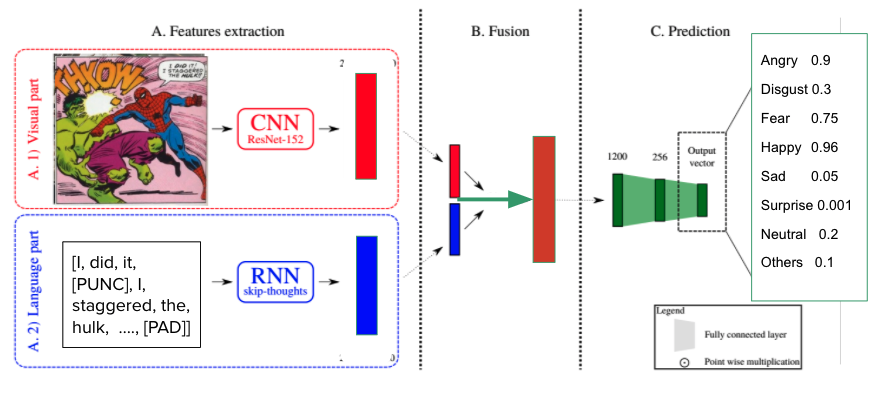

In [13]:
def create_model(configs):
  """
  create_model - function to create Visual-Textual model for Emotion Recognitin on Comic Scenes
  Inputs:
    - configs : dict
      Dicitonary of model configurations
  Outputs:
    - _ : Tensorflow Keras Model
  """

  # vision
  vision_model = vision(img_shape = configs['img_shape'])

  # text
  text_model = text(text_len = configs['text_len'], vocabs = configs['vocabs'],
    vocab_size = configs['vocab_size'], embed_dim = configs['embed_dim'],
    pretrained_embed = configs['pretrained_embed'])

  # fuse visiual and textual features
  vision_features = Conv2D(512, kernel_size = 3, strides = 1, activation = 'relu', padding = 'valid')(vision_model.outputs[0])
  vision_features = Reshape((-1, 512))(vision_features)

  """************************************"""
  outputs = tf.concat([vision_features, text_model.outputs[0]], axis = 1,
    name = 'fusion-concat')	
  """************************************"""

  # classfication module
  outputs = Flatten()(outputs)
  outputs = Dense(128, activation = 'relu')(outputs)
  outputs = Dense(configs['num_class'], activation = 'sigmoid')(outputs)

  return Model(inputs = [vision_model.inputs, text_model.inputs],
    outputs = outputs)

In [14]:
fusion_model = create_model(MODEL_CONFIGS)
print(fusion_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    image[0][0]                      
__________________________________________________________________________________________________
transcripts (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 5, 512)    9437696     resnet50[0][0]                   
____________________________________________________________________________________________

## Wait. Don't train your model. It takes a while. Let's use the pretrained model.

In [15]:
def _load_model(path):
        """
        _load_model - function load model for prediction
        Inputs:
                - path : str
                        Path to to-be-loaded model
        Ouptuts:
                - model : tf.keras.Model
        """

        # load model
        model = tf.keras.models.load_model(path)

        # freeeze model
        for idx in range(len(model.layers)):
                model.layers[idx].trainable = False
                model.layers[idx].training = False

        return model

In [16]:
pretrained_model = _load_model('/content/model')
print(pretrained_model.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    image[0][0]                      
__________________________________________________________________________________________________
transcripts (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 5, 512)    9437696     resnet50[0][0]                   
_______________________________________________________________________________________

## Prediction

In [28]:
# reshape imag & text to batch-styled
b_img = tf.expand_dims(img, axis = 0)
b_tokens = tf.expand_dims(d_tokens, axis = 0)

print("Shape of image", b_img.shape)
print("Shape of tokens", b_tokens.shape)

Shape of image (1, 224, 224, 3)
Shape of tokens (1, 128)


In [42]:
# make predictions
predictions = np.array(pretrained_model([b_img, b_tokens])[0])

Text: that ' s just the begin - ning ? ive even bigger jobs planned ha ha well make the police dance to the minstrel ' s tunes !

Angy - 0.38703623
Disgust - 0.14066747
Fear - 0.407984
Happy - 0.096317574
Sad - 0.07301684
Surprise - 0.4404111
Neutral - 0.98015714
Other - 0.0054265345


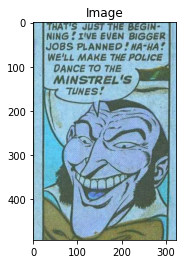

In [51]:
# print input
plt.imshow(image)
plt.title("Image")
print("Text:", text)


# print predictions
for type, prob in zip(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral', 'Other'], predictions):
  print(type, '-', prob)